# 전이학습 (Transfer Learing)

**Tensflow Version**

0. Install & Import

In [1]:
!pip install tensorflow tensorflow-datasets

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 804.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 166.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 128.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 8.4 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


1. Load Dataset (Cats vs Dogs — small subset)

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

(ds_train_full, ds_val_full), ds_info = tfds.load(
    "cats_vs_dogs",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)

ds_train = ds_train_full.take(4000)
ds_val = ds_val_full.take(1000)

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = ds_train.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(1)
val_ds = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(1)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.MQBSDH_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


2. Model Builder (Transfer / Scratch 둘 다 동일 구조 사용)

단, transfer 버전은 ImageNet weights 사용

In [3]:
def build_model(pretrained=True, trainable_base=False):
    if pretrained:
        base_model = tf.keras.applications.MobileNetV2(
            input_shape=IMG_SIZE + (3,),
            include_top=False,
            weights="imagenet"
        )
    else:
        base_model = tf.keras.applications.MobileNetV2(
            input_shape=IMG_SIZE + (3,),
            include_top=False,
            weights=None   # scratch!
        )

    base_model.trainable = trainable_base

    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(inputs, outputs)


3. Transfer Learning (Feature Extractor → Fine-tuning)

In [4]:
model_transfer = build_model(pretrained=True, trainable_base=False)

model_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print("===== Stage 1: Transfer Learning (Frozen Base) =====")
history_t1 = model_transfer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    verbose=2
)

# Fine-tuning 상단 30개 레이어 해동
base_model = model_transfer.layers[1]   # MobileNetV2 base model

base_model.trainable = True

fine_tune_at = 30  # top 30 layers trainable
for layer in base_model.layers[:-fine_tune_at]:
    layer.trainable = False

model_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print("\n===== Stage 2: Fine-tuning =====")
history_t2 = model_transfer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    verbose=2
)



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
===== Stage 1: Transfer Learning (Frozen Base) =====
Epoch 1/3
125/125 - 15s - 117ms/step - accuracy: 0.9165 - loss: 0.1985 - val_accuracy: 0.9680 - val_loss: 0.0942
Epoch 2/3
125/125 - 11s - 88ms/step - accuracy: 0.9730 - loss: 0.0764 - val_accuracy: 0.9760 - val_loss: 0.0693
Epoch 3/3
125/125 - 11s - 88ms/step - accuracy: 0.9803 - loss: 0.0606 - val_accuracy: 0.9790 - val_loss: 0.0653

===== Stage 2: Fine-tuning =====
Epoch 1/3
125/125 - 20s - 164ms/step - accuracy: 0.9525 - loss: 0.1207 - val_accuracy: 0.9720 - val_loss: 0.0807
Epoch 2/3
125/125 - 14s - 114ms/step - accuracy: 0.9905 - loss: 0.0318 - val_accuracy: 0.9770 - val_loss: 0.0832
Epoch 3/3
125/125 - 14s - 113ms/step - accuracy: 0.9950 - loss: 0.0164 - val_accuracy: 0.9630 - val_loss: 0.1267


4. Scratch Training (모든 Weight Random 초기화)

In [5]:
model_scratch = build_model(pretrained=False, trainable_base=True)

model_scratch.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print("===== Scratch Training =====")
history_s = model_scratch.fit(
    train_ds,
    validation_data=val_ds,
    epochs=6,  # transfer와 동일한 총 epoch 수
    verbose=2
)


===== Scratch Training =====
Epoch 1/6
125/125 - 70s - 560ms/step - accuracy: 0.5918 - loss: 0.6897 - val_accuracy: 0.4870 - val_loss: 0.6934
Epoch 2/6
125/125 - 53s - 423ms/step - accuracy: 0.6455 - loss: 0.6336 - val_accuracy: 0.4870 - val_loss: 0.6963
Epoch 3/6
125/125 - 53s - 423ms/step - accuracy: 0.6920 - loss: 0.5864 - val_accuracy: 0.4870 - val_loss: 0.6969
Epoch 4/6
125/125 - 52s - 419ms/step - accuracy: 0.7147 - loss: 0.5579 - val_accuracy: 0.4870 - val_loss: 0.7108
Epoch 5/6
125/125 - 53s - 423ms/step - accuracy: 0.7445 - loss: 0.5236 - val_accuracy: 0.4870 - val_loss: 0.7109
Epoch 6/6
125/125 - 52s - 418ms/step - accuracy: 0.7667 - loss: 0.4843 - val_accuracy: 0.4870 - val_loss: 0.7258


5. Compare Validation Accuracy

In [6]:
val_acc_transfer = model_transfer.evaluate(val_ds, verbose=0)[1]
val_acc_scratch = model_scratch.evaluate(val_ds, verbose=0)[1]

print("======================================")
print(f"Transfer Learning Final Acc: {val_acc_transfer:.4f}")
print(f"Scratch Training Final Acc:  {val_acc_scratch:.4f}")
print("======================================")


Transfer Learning Final Acc: 0.9630
Scratch Training Final Acc:  0.4870


6. Plot Learning Curves

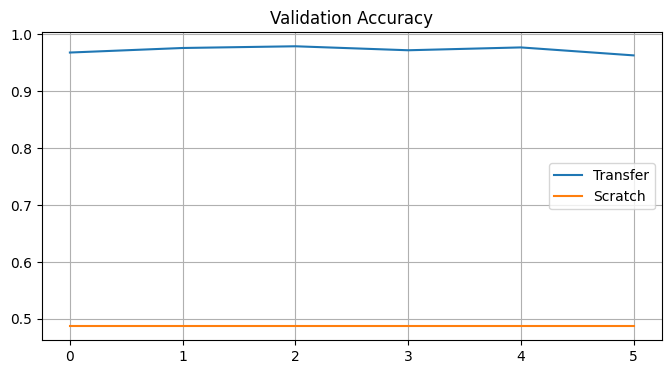

In [7]:
def plot_history(h1, h2, title):
    plt.figure(figsize=(8,4))
    plt.plot(h1, label="Transfer")
    plt.plot(h2, label="Scratch")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(
    history_t1.history["val_accuracy"] + history_t2.history["val_accuracy"],
    history_s.history["val_accuracy"],
    "Validation Accuracy"
)


결과 분석





*   ✅ (1) Stage 2에서 성능이 떨어졌다면?

Stage 1에서는 pretrained feature들을 그대로 사용해 안정적인 일반화를 얻었지만,
Stage 2에서 레이어를 해동하여 학습을 진행하면 pretrained weight가 흔들리거나 과적합이 발생할 수 있습니다.
특히 데이터가 적거나 fine-tuning 범위가 클 때 자주 나타나는 현상입니다.

요약 : **Stage 2 성능이 떨어졌다면, pretrained 모델의 안정적인 특징을 건드리면서 과적합이나 weight drift가 발생한 것입니다. 데이터 크기, fine-tuning 레이어 수, learning rate 등을 조절해야 합니다.**

*   ✅ (2)  Stage 2에서 성능이 올랐다면?

Stage 2에서 상위 레이어를 미세조정한 후 성능이 더 좋아졌다는 것은,
ImageNet으로 학습된 고수준 특징들이 우리 데이터셋(Cats vs Dogs)에 더 잘 맞게 조정되었다는 의미입니다.
즉, 모델이 pretrained 상태보다 데이터셋의 특성에 더 민감한 구분 기준을 학습한 것입니다.

요약: **Stage 2에서 성능이 오른 경우는, fine-tuning 과정이 실제로 pretrained 모델을 더 우리 데이터에 최적화시켰다는 뜻입니다.**


****

참고: 신경망 학습의 랜덤성

신경망의 학습에는 랜덤성이 존재하기 때문에, 같은 설정이라도 다시 실행하면 성능이 오르거나 떨어질 수 있습니다.
따라서 두 가지 방법의 성능을 공정하게 비교하려면 여러 번 반복 실행한 결과의 평균 성능을 사용해야 합니다.
예를 들어, 보통 10회 또는 100회 반복(run)의 평균값을 비교 기준으로 삼습니다.

이렇게 여러 번의 결과를 요약할 때 가장 많이 쓰는 표현이 mean ± std(평균 ± 표준편차)입니다.
e.g., accuracy = 91.2 ± 0.8 (%).

**Pytorch Version**

In [ ]:
!pip install torch torchvision tensorflow_datasets

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import tensorflow_datasets as tfds
import numpy as np
from tqdm import tqdm


In [ ]:
IMG_SIZE = 160

# Load TFDS
(ds_train_full, ds_val_full), _ = tfds.load(
    "cats_vs_dogs",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)

# Take small subset
ds_train_full = ds_train_full.take(4000)
ds_val_full = ds_val_full.take(1000)

# TFDS → PyTorch Dataset
class TFDataset(Dataset):
    def __init__(self, tf_dataset, transform=None):
        self.data = list(tf_dataset)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        img = img.numpy()

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.float32)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

train_ds = TFDataset(ds_train_full, transform)
val_ds = TFDataset(ds_val_full, transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)


In [ ]:
def build_model(pretrained=True, fine_tune_layers=30):
    model = models.mobilenet_v2(pretrained=pretrained)

    # Replace classifier
    model.classifier[1] = nn.Linear(model.last_channel, 1)

    # Fine-tuning 여부 설정
    if pretrained:
        for param in model.parameters():
            param.requires_grad = False

        # 상위 N개 레이어만 해동
        train_layers = list(model.features[-fine_tune_layers:].parameters())
        for p in train_layers:
            p.requires_grad = True
    else:
        # scratch: 전부 학습
        for param in model.parameters():
            param.requires_grad = True

    return model


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, val_loader, epochs=3, lr=1e-3):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_acc = 0

        for imgs, labels in tqdm(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()*imgs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            total_acc += (preds == labels).sum().item()

        train_loss = total_loss / len(train_loader.dataset)
        train_acc = total_acc / len(train_loader.dataset)

        # Validation
        model.eval()
        total_acc = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs).squeeze(1)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                total_acc += (preds == labels).sum().item()

        val_acc = total_acc / len(val_loader.dataset)

        print(f"[Epoch {epoch+1}/{epochs}] Train Loss: {train_loss:.4f} "
              f"Train Acc: {train_acc:.4f}  Val Acc: {val_acc:.4f}")

    return model


In [ ]:
print("===== Stage 1: Transfer Learning (Frozen Base) =====")
model_transfer = build_model(pretrained=True, fine_tune_layers=0)
model_transfer = train_model(model_transfer, train_loader, val_loader, epochs=3, lr=1e-3)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


===== Stage 1: Transfer Learning (Frozen Base) =====
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 227MB/s]
100%|██████████| 125/125 [02:28<00:00,  1.19s/it]


[Epoch 1/3] Train Loss: 0.2151 Train Acc: 0.9145  Val Acc: 0.9650


100%|██████████| 125/125 [02:22<00:00,  1.14s/it]


[Epoch 2/3] Train Loss: 0.1054 Train Acc: 0.9550  Val Acc: 0.9620


100%|██████████| 125/125 [02:23<00:00,  1.14s/it]


[Epoch 3/3] Train Loss: 0.0896 Train Acc: 0.9653  Val Acc: 0.9640


In [ ]:
print("\n===== Stage 2: Fine-tuning (Top 30 Layers) =====")
model_transfer = build_model(pretrained=True, fine_tune_layers=30)
model_transfer.load_state_dict(model_transfer.state_dict())  # reuse classifier
model_transfer = train_model(model_transfer, train_loader, val_loader, epochs=3, lr=1e-4)



===== Stage 2: Fine-tuning (Top 30 Layers) =====


100%|██████████| 125/125 [02:22<00:00,  1.14s/it]


[Epoch 1/3] Train Loss: 0.1482 Train Acc: 0.9420  Val Acc: 0.9750


100%|██████████| 125/125 [02:21<00:00,  1.14s/it]


[Epoch 2/3] Train Loss: 0.0439 Train Acc: 0.9862  Val Acc: 0.9790


100%|██████████| 125/125 [02:21<00:00,  1.13s/it]


[Epoch 3/3] Train Loss: 0.0174 Train Acc: 0.9958  Val Acc: 0.9830


In [ ]:
print("\n===== Scratch Training (Random Init) =====")
model_scratch = build_model(pretrained=False)
model_scratch = train_model(model_scratch, train_loader, val_loader, epochs=6, lr=1e-3)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



===== Scratch Training (Random Init) =====


100%|██████████| 125/125 [02:21<00:00,  1.13s/it]


[Epoch 1/6] Train Loss: 0.6807 Train Acc: 0.5867  Val Acc: 0.5560


100%|██████████| 125/125 [02:22<00:00,  1.14s/it]


[Epoch 2/6] Train Loss: 0.6508 Train Acc: 0.6152  Val Acc: 0.6180


100%|██████████| 125/125 [02:20<00:00,  1.12s/it]


[Epoch 3/6] Train Loss: 0.6237 Train Acc: 0.6560  Val Acc: 0.6250


100%|██████████| 125/125 [02:21<00:00,  1.14s/it]


[Epoch 4/6] Train Loss: 0.5787 Train Acc: 0.6940  Val Acc: 0.6520


100%|██████████| 125/125 [02:22<00:00,  1.14s/it]


[Epoch 5/6] Train Loss: 0.5472 Train Acc: 0.7275  Val Acc: 0.6570


100%|██████████| 125/125 [02:22<00:00,  1.14s/it]


[Epoch 6/6] Train Loss: 0.5128 Train Acc: 0.7510  Val Acc: 0.7000


In [ ]:
def evaluate(model):
    model.eval()
    model = model.to(device)
    total_acc = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs).squeeze(1)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            total_acc += (preds == labels).sum().item()
    return total_acc / len(val_loader.dataset)


In [ ]:
acc_transfer = evaluate(model_transfer)
acc_scratch = evaluate(model_scratch)

print("======================================")
print(f"Transfer Learning Final Acc: {acc_transfer:.4f}")
print(f"Scratch Training Final Acc:  {acc_scratch:.4f}")
print("======================================")


Transfer Learning Final Acc: 0.9830
Scratch Training Final Acc:  0.7000
